#Librerie e funzioni

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import zipfile
from skimage.filters import laplace, sobel
import os
import cv2
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
#Estrazione dei file nell'ambiente Colab
image_data = zipfile.ZipFile('/content/gdrive/MyDrive/DSIM/image_classification/archive.zip')
image_data.extractall()
image_data.close()

In [ ]:
 #Estrazione features dalle immagini
 def get_data():
    path = '/content/'
    features=[]
    for label in ['sharp/', 'defocused_blurred/', 'motion_blurred/']:
      for img in os.listdir(path+label):
          feature = []
          feature.append(device(img))
          image_grey = cv2.imread(path+label+img,0)
          feature.extend(sobel_filter(image_grey)) #media, varianza e massimo del filtro di Sobel
          feature.extend(laplace_filter(image_grey)) #media, varianza e massimo del filtro di Laplace
          features.append(feature)

    return features

In [ ]:
def sobel_filter(input):
  sob_feat = sobel(input)
  return sob_feat.mean(),sob_feat.var(),np.max(sob_feat)

def laplace_filter(input):
  lap_feat = laplace(input)
  return lap_feat.mean(),lap_feat.var(),np.max(lap_feat)

def device(path):
  return path.split('_')[1]


#Creazione Dataset

In [ ]:
dataset = pd.DataFrame(get_data())

In [ ]:
dataset.rename(
    {
        0:'device',
        1:'sob_mean',
        2:'sob_var',
        3:'sob_max',
        4:'lap_mean',
        5:'lap_var',
        6:'lap_max'
     },
     axis = 1,
     inplace = True)

In [ ]:
dataset.head()

,device,sob_mean,sob_var,sob_max,lap_mean,lap_var,lap_max
0,HONOR-7C,0.014539,0.000203,0.343168,-0.000001,0.000606,0.717647
1,HONOR-8X,0.018402,0.001574,0.708025,0.000003,0.006006,2.019608
2,IPHONE-SE,0.013937,0.000341,0.539263,-0.000001,0.001073,1.403922
3,XIAOMI-PROCOFONE-F1,0.020929,0.001467,0.543676,0.000006,0.007951,1.278431
4,IPHONE-8-PLUS,0.025338,0.001988,0.513378,0.000003,0.010057,1.670588


In [ ]:
#Categorizzazione della variabile 'device' tramite One-hot Encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder()
dataset_he = pd.concat([dataset, pd.DataFrame(to_categorical(le.fit_transform(dataset['device']), dtype='int'))], axis=1)

In [ ]:
dataset_he

,device,sob_mean,sob_var,sob_max,lap_mean,lap_var,lap_max,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,HONOR-7C,0.014539,0.000203,0.343168,-1.194275e-06,0.000606,0.717647,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HONOR-8X,0.018402,0.001574,0.708025,2.957014e-06,0.006006,2.019608,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,IPHONE-SE,0.013937,0.000341,0.539263,-1.136929e-06,0.001073,1.403922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,XIAOMI-PROCOFONE-F1,0.020929,0.001467,0.543676,5.915274e-06,0.007951,1.278431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,IPHONE-8-PLUS,0.025338,0.001988,0.513378,3.107856e-06,0.010057,1.670588,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,NIKON-D3400-18-55MM,0.010176,0.000118,0.434955,-2.504006e-06,0.000836,0.811765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,HUAWEI-NOVA-LITE,0.009892,0.000059,0.238928,-6.370295e-07,0.001384,0.631373,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1047,WILEYFOX-SWIFT-2-PLUS,0.011121,0.000079,0.241503,9.848401e-07,0.002279,0.819608,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1048,NIKON-D3400-35MM,0.021482,0.000501,0.503019,-2.018636e-06,0.001854,1.027451,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Eliminiamo la variabile 'device' originale
dataset_he = dataset_he.drop(['device'], axis = 1)

In [ ]:
dataset_he.head()

,sob_mean,sob_var,sob_max,lap_mean,lap_var,lap_max,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,0.014539,0.000203,0.343168,-0.000001,0.000606,0.717647,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.018402,0.001574,0.708025,0.000003,0.006006,2.019608,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.013937,0.000341,0.539263,-0.000001,0.001073,1.403922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.020929,0.001467,0.543676,0.000006,0.007951,1.278431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.025338,0.001988,0.513378,0.000003,0.010057,1.670588,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Creazione variabile risposta e analisi esplorative

In [ ]:
y = np.concatenate((np.repeat('sharp', 350), np.repeat('defocused', 350), np.repeat('motion', 350)))

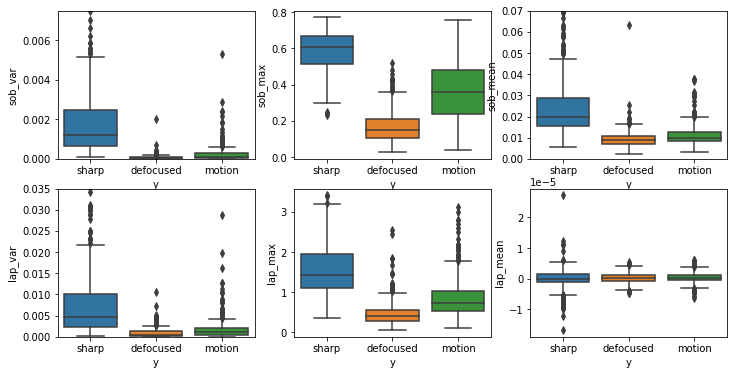

In [ ]:
plt.rcParams.update({'figure.figsize':(12,6)})
f, axis = plt.subplots(2,3)

ax1 = sns.boxplot(x="y", y="sob_var", data=pd.concat([dataset_he, pd.DataFrame(y, columns=['y'])], axis = 1,),
                  ax = axis[0,0])
ax1.set(ylim = (0,0.0075)) 
ax2 = sns.boxplot(x="y", y="sob_max", data=pd.concat([dataset_he, pd.DataFrame(y, columns=['y'])], axis = 1),
                  ax = axis[0,1])
ax3 = sns.boxplot(x="y", y="sob_mean", data=pd.concat([dataset_he, pd.DataFrame(y, columns=['y'])], axis = 1),
                  ax = axis[0,2])
ax3.set(ylim = (0,0.07))
ax4 = sns.boxplot(x="y", y="lap_var", data=pd.concat([dataset_he, pd.DataFrame(y, columns=['y'])], axis = 1),
                  ax = axis[1,0])
ax4.set(ylim = (0,0.035))
ax5 = sns.boxplot(x="y", y="lap_max", data=pd.concat([dataset_he, pd.DataFrame(y, columns=['y'])], axis = 1),
                  ax = axis[1,1])
ax6 = sns.boxplot(x="y", y="lap_mean", data=pd.concat([dataset_he, pd.DataFrame(y, columns=['y'])], axis = 1),
                  ax = axis[1,2])
plt.show()

Dai boxplot delle 6 variabili emerge che le immagini più definite (sharp) presentano generalmente valori di massimo e varianza più elevati per entrambi i filtri.

#Primo Approccio: ML & Feature Engineering

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(dataset_he,y,test_size=0.33)

Per tutti i modelli sono state testate più configurazioni di iperparametri tramite `GridSearchCV()`

##Decision Tree esplorativo

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
pred_tree =decision_tree.predict(X_test)
print('Confusion matrix:\n',confusion_matrix(y_test,pred_tree))
print('Classification_report:\n',classification_report(y_test,pred_tree))

Confusion matrix:
 [[74 40  3]
 [23 55 28]
 [ 3 27 94]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.74      0.63      0.68       117
      motion       0.45      0.52      0.48       106
       sharp       0.75      0.76      0.76       124

    accuracy                           0.64       347
   macro avg       0.65      0.64      0.64       347
weighted avg       0.66      0.64      0.65       347



In [ ]:
importance = pd.DataFrame(decision_tree.feature_importances_, index=dataset_he.columns,
                          columns = ['variable_importance'])
importance.sort_values(by='variable_importance', ascending=False)

,variable_importance
sob_var,0.402606
sob_max,0.218108
lap_max,0.100620
sob_mean,0.071290
lap_mean,0.062957
...,...
6,0.000000
36,0.000000
38,0.000000
39,0.000000


Poichè la variabile device risulta poco significativa e in ottica di utilizzo futuro si suppone che i device potrebbero cambiare, si decide di rimuoverla dall'analisi.

In [ ]:
dataset_he_rid = dataset_he.iloc[:,0:6]
#Eliminata variabile device

In [ ]:
dataset_he_rid.head()

,sob_mean,sob_var,sob_max,lap_mean,lap_var,lap_max
0,0.014539,0.000203,0.343168,-0.000001,0.000606,0.717647
1,0.018402,0.001574,0.708025,0.000003,0.006006,2.019608
2,0.013937,0.000341,0.539263,-0.000001,0.001073,1.403922
3,0.020929,0.001467,0.543676,0.000006,0.007951,1.278431
4,0.025338,0.001988,0.513378,0.000003,0.010057,1.670588


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(dataset_he_rid,y,test_size=0.33)

##SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}
                   
clf = GridSearchCV(SVC(), tuned_parameters, scoring = 'accuracy')
clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
clf.best_estimator_

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
tuned_parameters = {'gamma': [1e-3,1e-2],
                     'C': [500, 1000, 2000]}
                   
clf = GridSearchCV(SVC(), tuned_parameters, scoring = 'accuracy')
clf.fit(X_train, y_train)
clf.best_estimator_

SVC(C=2000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
tuned_parameters = {'gamma': [1e-2, 1e-1],
                     'C': [2000, 4000, 6000]}
                   
clf = GridSearchCV(SVC(probability = True), tuned_parameters, scoring = 'accuracy')
clf.fit(X_train, y_train)
clf.best_estimator_

SVC(C=6000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
pred_svm = clf.predict(X_test)
print('Confusion matrix:\n',confusion_matrix(y_test,pred_svm))
print('Classification_report:\n',classification_report(y_test,pred_svm))

Confusion matrix:
 [[112  13   0]
 [ 31  52  23]
 [  0  23  93]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.78      0.90      0.84       125
      motion       0.59      0.49      0.54       106
       sharp       0.80      0.80      0.80       116

    accuracy                           0.74       347
   macro avg       0.73      0.73      0.72       347
weighted avg       0.73      0.74      0.73       347



La miglior combinazione di parametri per la SVM `(C = 6000 e gamma = 0.1)`, ha portato ad un'accuratezza del 74%.

In [ ]:
#Salvataggio delle probabilità a posteriori per il modello 'ensemble'
prob_train_svm = clf.predict_proba(X_train)
prob_test_svm = clf.predict_proba(X_test)

##Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
pred_tree = decision_tree.predict(X_test)
print('Confusion matrix:\n',confusion_matrix(y_test,pred_tree))
print('Classification_report:\n',classification_report(y_test,pred_tree))

Confusion matrix:
 [[86 39  0]
 [20 63 23]
 [ 2 23 91]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.80      0.69      0.74       125
      motion       0.50      0.59      0.55       106
       sharp       0.80      0.78      0.79       116

    accuracy                           0.69       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.71      0.69      0.70       347



In [ ]:
#Salvataggio delle probabilità a posteriori per il modello 'ensemble'
prob_train_tree = decision_tree.predict_proba(X_train)
prob_test_tree = decision_tree.predict_proba(X_test)

##KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print('Confusion matrix:\n',confusion_matrix(y_test,pred_knn))
print('Classification_report:\n',classification_report(y_test,pred_knn))

Confusion matrix:
 [[102  22   1]
 [ 31  46  29]
 [  0  23  93]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.77      0.82      0.79       125
      motion       0.51      0.43      0.47       106
       sharp       0.76      0.80      0.78       116

    accuracy                           0.69       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.69      0.69       347



Per questo modello, sono stati provati diversi valori per il numero di vicini, rispettivamente 3,5 e 7. Il miglior risultato si è ottenuto con `k = 5`.

In [ ]:
#Salvataggio delle probabilità a posteriori per il modello 'ensemble'
prob_train_knn = knn.predict_proba(X_train)
prob_test_knn = knn.predict_proba(X_test)

##Random Forest

In [ ]:
rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [5, 10, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12 ],
    'n_estimators': [50, 100]
}

rf = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'accuracy', n_jobs=-1, verbose = 2)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print('Confusion matrix:\n',confusion_matrix(y_test,pred_rf))
print('Classification_report:\n',classification_report(y_test,pred_rf))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   30.8s


Confusion matrix:
 [[104  21   0]
 [ 25  61  20]
 [  0  18  98]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.81      0.83      0.82       125
      motion       0.61      0.58      0.59       106
       sharp       0.83      0.84      0.84       116

    accuracy                           0.76       347
   macro avg       0.75      0.75      0.75       347
weighted avg       0.75      0.76      0.76       347



[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   54.0s finished


In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [20, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 6, 8, 10 ],
    'n_estimators': [50, 100]
}

rf = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'accuracy', n_jobs=-1, verbose = 3)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print('Confusion matrix:\n',confusion_matrix(y_test,pred_rf))
print('Classification_report:\n',classification_report(y_test,pred_rf))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   30.3s


Confusion matrix:
 [[107  18   0]
 [ 22  66  18]
 [  0  17  99]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.83      0.86      0.84       125
      motion       0.65      0.62      0.64       106
       sharp       0.85      0.85      0.85       116

    accuracy                           0.78       347
   macro avg       0.78      0.78      0.78       347
weighted avg       0.78      0.78      0.78       347



[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   50.6s finished


La miglior combinazione di parametri per la Random Forest (`max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50`) ha portato ad un'accuratezza del 78%.

In [ ]:
#Salvataggio delle probabilità a posteriori per il modello 'ensemble'
prob_train_rf = rf.predict_proba(X_train)
prob_test_rf = rf.predict_proba(X_test)

##Ensemble

In [ ]:
#Creazione DataFrame (partizione di train) con probabilità a posteriori delle 3 classi
prob_train = pd.concat([
           pd.DataFrame(prob_train_svm, columns = ['{}_svm'.format(i) for i in range(3)]),
           pd.DataFrame(prob_train_knn, columns = ['{}_knn'.format(i) for i in range(3)]),
           pd.DataFrame(prob_train_tree, columns = ['{}_tree'.format(i) for i in range(3)]),
           pd.DataFrame(prob_train_rf, columns = ['{}_rf'.format(i) for i in range(3)])
], axis = 1)
prob_train

,0_svm,1_svm,2_svm,0_knn,1_knn,2_knn,0_tree,1_tree,2_tree,0_rf,1_rf,2_rf
0,0.772069,0.217404,0.010527,0.8,0.2,0.0,1.0,0.0,0.0,0.914025,0.085975,0.000000
1,0.002229,0.178930,0.818841,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.114983,0.885017
2,0.779424,0.214896,0.005680,1.0,0.0,0.0,1.0,0.0,0.0,0.681957,0.318043,0.000000
3,0.746226,0.246390,0.007384,0.6,0.4,0.0,1.0,0.0,0.0,0.933529,0.066471,0.000000
4,0.004446,0.012513,0.983041,0.0,0.2,0.8,0.0,0.0,1.0,0.000000,0.032129,0.967871
...,...,...,...,...,...,...,...,...,...,...,...,...
698,0.650633,0.332445,0.016922,0.6,0.4,0.0,0.0,1.0,0.0,0.420571,0.578096,0.001333
699,0.000860,0.066971,0.932168,0.0,0.4,0.6,0.0,1.0,0.0,0.004444,0.342341,0.653215
700,0.636989,0.346227,0.016784,0.6,0.4,0.0,1.0,0.0,0.0,0.631080,0.366698,0.002222
701,0.528757,0.424937,0.046306,0.4,0.2,0.4,1.0,0.0,0.0,0.588588,0.344904,0.066508


In [ ]:
#Creazione DataFrame (partizione di test) con probabilità a posteriori delle 3 classi
prob_test = pd.concat([
           pd.DataFrame(prob_test_svm, columns = ['{}_svm'.format(i) for i in range(3)]),
           pd.DataFrame(prob_test_knn, columns = ['{}_knn'.format(i) for i in range(3)]),
           pd.DataFrame(prob_test_tree, columns = ['{}_tree'.format(i) for i in range(3)]),
           pd.DataFrame(prob_test_rf, columns = ['{}_rf'.format(i) for i in range(3)])
], axis = 1)

Viene utilizzato un modello Logistico ed una Random Forest, per classificare le immagini date le variabili precedentemente create.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(
    prob_train, y_train
)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred_log_reg = log_reg.predict(prob_test)
print('Confusion matrix:\n',confusion_matrix(y_test, pred_log_reg))
print('Classification_report:\n',classification_report(y_test, pred_log_reg))

Confusion matrix:
 [[86 39  0]
 [20 63 23]
 [ 2 23 91]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.80      0.69      0.74       125
      motion       0.50      0.59      0.55       106
       sharp       0.80      0.78      0.79       116

    accuracy                           0.69       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.71      0.69      0.70       347



In [ ]:
param_grid = {
    'max_depth': [5, 10, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12 ],
    'n_estimators': [50, 100]
}

rf_ens = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'accuracy', n_jobs=-1, verbose = 2)
rf_ens.fit(prob_train, y_train)
pred_rf_ens = rf_ens.predict(prob_test)
print('Confusion matrix:\n',confusion_matrix(y_test, pred_rf_ens))
print('Classification_report:\n',classification_report(y_test, pred_rf_ens))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   31.9s


Confusion matrix:
 [[86 39  0]
 [20 63 23]
 [ 2 23 91]]
Classification_report:
               precision    recall  f1-score   support

   defocused       0.80      0.69      0.74       125
      motion       0.50      0.59      0.55       106
       sharp       0.80      0.78      0.79       116

    accuracy                           0.69       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.71      0.69      0.70       347



[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   47.0s finished


Il miglior modello per quanto riguarda l'approccio ML è Random Forest (accuratezza pari al 78%)

In [ ]:
import matplotlib.pyplot as plt
 

performance = pd.DataFrame({'Model': ['Decision Tree', 'SVM', 'KNN', 'Random Forest', 'Ensemble'],
              'Accuracy': [0.69, 0.74, 0.69, 0.78, 0.69]}).sort_values(by = 'Accuracy', ascending = False)

<BarContainer object of 5 artists>

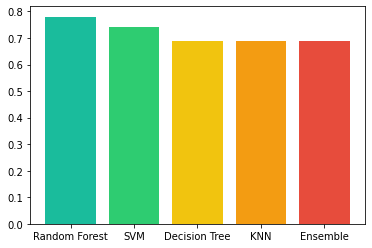

In [ ]:
plt.bar(performance['Model'], performance['Accuracy'], color = ['#1abc9c', '#2ecc71',
                                                                '#f1c40f','#f39c12','#E74C3C'])